In [1]:
import torch, pickle, time, os
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric as tg
from torch_geometric.loader import DataLoader
# if torch.cuda.is_available():
#     from accelerate import Accelerator
#     accelerator = Accelerator()
#     device = accelerator.device
### accelerate huggingface to GPU

In [2]:
os.listdir('../../../../scratch/gpfs/cj1223/GraphStorage/')

['medium_beforeafter',
 'test_onlyhmass_smass',
 'test_cut',
 'medium_all_q_diffbeforeafter',
 'medium_all_smass',
 'medium_onlyhmass_smass',
 'test_beforeafter',
 'test_all_smass',
 'transformers',
 'medium_all_variance',
 'medium_all_q',
 'medium_all_final',
 'test_variance',
 'small_all_q_variancehalomass',
 'medium_all_residual',
 'medium_all',
 'test',
 'test_final',
 'med_all_residual',
 'one_all_q',
 'test_redshift_scan',
 'medium_all_finalhalo',
 '105lim_all_smass',
 'small_all_q']

In [3]:
case='medium_all_residual'
case='test_redshift_scan'
data=pickle.load(open(f'../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'rb'))
print(len(data))

769


In [4]:
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, LayerNorm
from torch_geometric.nn import SAGEConv, global_mean_pool, norm, global_max_pool, global_add_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, nlin=3):
        super(GCN, self).__init__()
        
        self.conv1 = SAGEConv(data[0].num_node_features, hidden_channels) ##use meta-layer
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.meta.MetaLayer
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        
        # Our final linear layer will define our output
        self.norm = LayerNorm(normalized_shape=hidden_channels) # layer_norm instead
        self.lin1 = Linear(hidden_channels, 1)
        
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
#         x = self.conv3(x, edge_index)   

          # 2. Readout layer
#         x = global_max_pool(x, batch)  ## Miles says use sumpool
#         x = global_mean_pool(x, batch)
#         x=concat(x1,x2)
        x = global_add_pool(x, batch)  ## Miles says use sumpool

#         x = F.dropout(x, p=0.1, training=self.training)

        x = self.lin1(self.norm(x))
#         x=self.lin1(x)
        return x
    
model = GCN(hidden_channels=32)
next(model.parameters()).is_cuda ##check number one

False

In [7]:
criterion = torch.nn.MSELoss()
n_epochs=100
batch_size=64
split=0.8
np.random.shuffle(data)
test_data=data[int(len(data)*split):]
train_data=data[:int(len(data)*split)]

In [8]:
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=1)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=1)    
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
# _, _, test_loader = accelerator.prepare(model, optimizer, train_loader)
# model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

# Initialize our train function
def train():
    model.train()
 
    for data in train_loader:  
        out = model(data.x, data.edge_index, data.batch)  
        loss = criterion(out, data.y.view(-1,1)) 
        loss.backward()
#         accelerator.backward(loss)
        optimizer.step() 
        optimizer.zero_grad() 
 # test function
def test(loader):
    model.eval()
 
    correct = 0
    for dat in loader: 
        out = model(dat.x, dat.edge_index, dat.batch) 
#         print(out)
        correct += (torch.square(out - dat.y.view(-1,1))).sum() 
    return correct / len(loader.dataset) 
tr_acc, te_acc=[],[]
start=time.time()
for epoch in range(n_epochs):
    train()
    
    if (epoch+1)%2==0:
        train_acc = test(train_loader).detach().numpy()
        test_acc = test(test_loader).detach().numpy()
        tr_acc.append(train_acc)
        te_acc.append(test_acc)
        print(f'Epoch: {epoch+1:03d}, Train scatter: {np.sqrt(train_acc):.4f}, Test scatter: {np.sqrt(test_acc):.4f}')
stop=time.time()
spent=stop-start
print(f"{spent:.2f} seconds spent training, {spent/n_epochs:.3f} seconds per epoch. Processed {len(data)*split*n_epochs/spent:.0f} trees per second")

Epoch: 002, Train scatter: 0.2245, Test scatter: 0.2049
Epoch: 004, Train scatter: 0.2144, Test scatter: 0.1984
Epoch: 006, Train scatter: 0.2089, Test scatter: 0.1952
Epoch: 008, Train scatter: 0.2053, Test scatter: 0.1934
Epoch: 010, Train scatter: 0.2027, Test scatter: 0.1932
Epoch: 012, Train scatter: 0.1998, Test scatter: 0.1914
Epoch: 014, Train scatter: 0.1982, Test scatter: 0.1917
Epoch: 016, Train scatter: 0.1960, Test scatter: 0.1922
Epoch: 018, Train scatter: 0.2072, Test scatter: 0.2033
Epoch: 020, Train scatter: 0.1927, Test scatter: 0.1892
Epoch: 022, Train scatter: 0.1911, Test scatter: 0.1884
Epoch: 024, Train scatter: 0.1928, Test scatter: 0.1914
Epoch: 026, Train scatter: 0.1872, Test scatter: 0.1867
Epoch: 028, Train scatter: 0.1958, Test scatter: 0.1952
Epoch: 030, Train scatter: 0.1837, Test scatter: 0.1849
Epoch: 032, Train scatter: 0.1856, Test scatter: 0.1870
Epoch: 034, Train scatter: 0.1904, Test scatter: 0.1922
Epoch: 036, Train scatter: 0.2038, Test scatter:

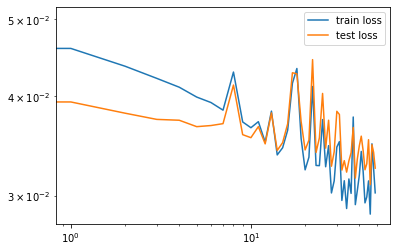

In [9]:
plt.plot(tr_acc, label='train loss')
plt.plot(te_acc, label='test loss')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [10]:
ys, pred=[],[]
def test(loader):
    model.eval()
 
    correct = 0
    for dat in loader: 
        out = model(dat.x, dat.edge_index, dat.batch) 
        pred.append(out.view(1,-1).detach().numpy())
        ys.append(np.array(dat.y)) 
test(test_loader)
# test(train_loader)
ys=np.hstack(ys)
pred=np.hstack(pred)[0]

[Text(0.5, 1.0, 'Residuals, scatter is 0.17'),
 Text(0.5, 0, 'log10(M_stellar)_true-log10(M_stellar)_predicted'),
 Text(0, 0.5, 'N')]

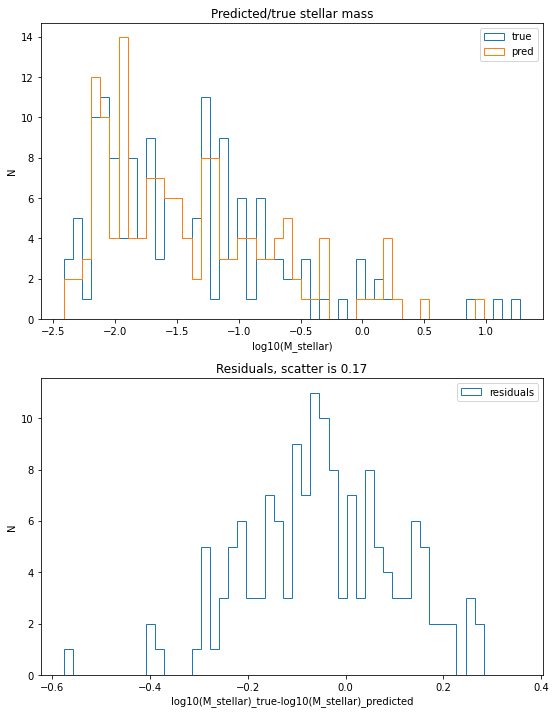

In [11]:
fig, ax= plt.subplots(2, figsize=(9,12))
bins=50
ax[0].hist(ys, bins=bins, range=(np.percentile(np.hstack([ys,pred]), [1,99])), label='true',  histtype='step')
ax[0].hist(pred, bins=bins, range=(np.percentile(np.hstack([ys,pred]), [1,99])), label='pred', histtype='step')
ax[1].hist((ys-pred), bins=bins,range=(np.percentile(ys-pred, [1,99])),  histtype='step', label='residuals');
ax[0].legend()
ax[1].legend()
ax[0].set(title='Predicted/true stellar mass', xlabel='log10(M_stellar)', ylabel='N')
ax[1].set(title=f'Residuals, scatter is {np.std(ys-pred):.2f}',
          xlabel='log10(M_stellar)_true-log10(M_stellar)_predicted', ylabel='N')

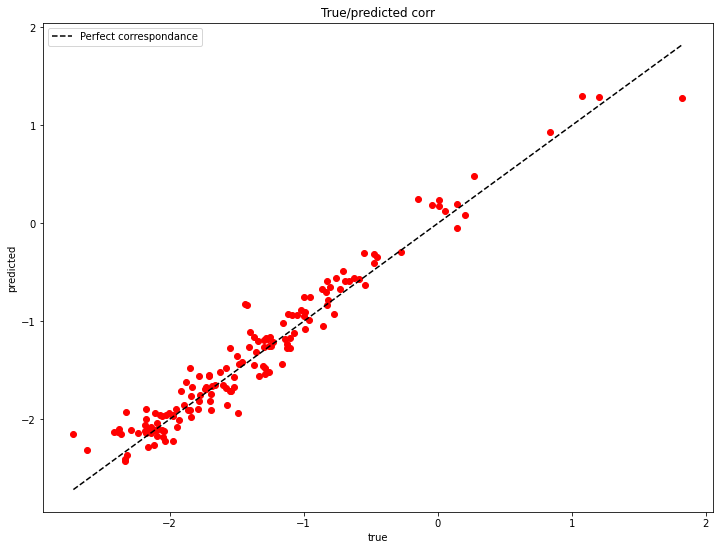

In [12]:
fig, ax =plt.subplots(figsize=(12,9))
ax.plot(ys,pred, 'ro')
ax.plot([min(ys),max(ys)],[min(ys),max(ys)], 'k--', label='Perfect correspondance')
ax.set(xlabel='true',ylabel='predicted', title='True/predicted corr')
ax.legend()

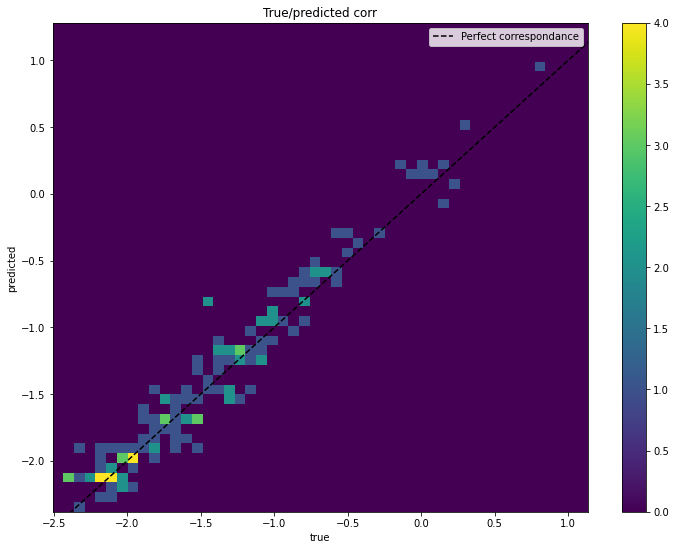

In [13]:
fig, ax =plt.subplots(figsize=(12,9))
h = ax.hist2d(ys,pred, bins=50, range=[np.percentile(ys, [1,99]),np.percentile(pred, [1,99])])
fig.colorbar(h[3], ax=ax)
ax.plot([min(ys),max(ys)],[min(ys),max(ys)], 'k--', label='Perfect correspondance')
ax.set(xlabel='true',ylabel='predicted', title='True/predicted corr')
ax.legend()

In [16]:
x,y=[], []
for d in data:
    x.append(d.x[0,3].numpy())
    y.append(d.y.numpy())    

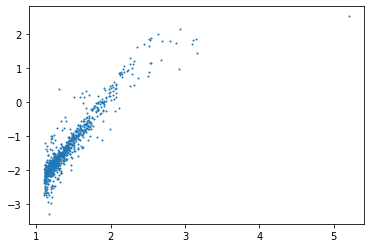

In [17]:
plt.plot(x, y, 'o', markersize=1) 

In [18]:
data

[Data(x=[34, 4], edge_index=[2, 33], edge_attr=[33], y=-1.0937798023223877),
 Data(x=[15, 4], edge_index=[2, 14], edge_attr=[14], y=-1.5345278978347778),
 Data(x=[19, 4], edge_index=[2, 18], edge_attr=[18], y=-1.9550096988677979),
 Data(x=[18, 4], edge_index=[2, 17], edge_attr=[17], y=-1.6602762937545776),
 Data(x=[8, 4], edge_index=[2, 7], edge_attr=[7], y=-1.9204931259155273),
 Data(x=[25, 4], edge_index=[2, 24], edge_attr=[24], y=-1.458103895187378),
 Data(x=[22, 4], edge_index=[2, 21], edge_attr=[21], y=-2.2496466636657715),
 Data(x=[9, 4], edge_index=[2, 8], edge_attr=[8], y=-1.9324381351470947),
 Data(x=[1488, 4], edge_index=[2, 1487], edge_attr=[1487], y=1.7260764837265015),
 Data(x=[273, 4], edge_index=[2, 272], edge_attr=[272], y=1.3066201210021973),
 Data(x=[18, 4], edge_index=[2, 17], edge_attr=[17], y=-2.183887243270874),
 Data(x=[32, 4], edge_index=[2, 31], edge_attr=[31], y=-0.9758962392807007),
 Data(x=[38, 4], edge_index=[2, 37], edge_attr=[37], y=-0.6699191927909851),


In [ ]:
## remember to validate that test/val/train are actually comparable
## create toy problem (predict variance of all halo masses eg, verifying that in takes into account edges)
## same, predict average of the difference of post-merge halo and pre merger halos

## try different pools